# 0. Instalacja pakietu 

In [1]:
!pip install gymnasium


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import argparse
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import clear_output

# 1. Przestrzeń dyskretna

New best reward: -424 in episode 0
New best reward: -379 in episode 1
New best reward: -370 in episode 2
New best reward: -325 in episode 4
New best reward: -280 in episode 8
New best reward: -110 in episode 55
New best reward: -106 in episode 141
New best reward: -79 in episode 173
New best reward: -39 in episode 216
New best reward: -23 in episode 252
New best reward: -11 in episode 271
New best reward: 12 in episode 353
New best reward: 13 in episode 551
New best reward: 14 in episode 604
New best reward: 15 in episode 864
Q-tabela (fragment):
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.3470015   -3.42105457  -3.34406909  -3.35388135  -3.32458551
   -8.21229634]
 [ -2.25253401  -2.04379342  -2.26450682  -2.21415568   0.71432519
   -3.50429581]
 [ -2.94534901  -2.89897528  -2.8800535   -2.81085548  -2.61080142
   -6.90972913]
 [ -3.94226085  -3.89143796  -3.9288349   -3.87582927  -6.82062384
  -10.43649456]]


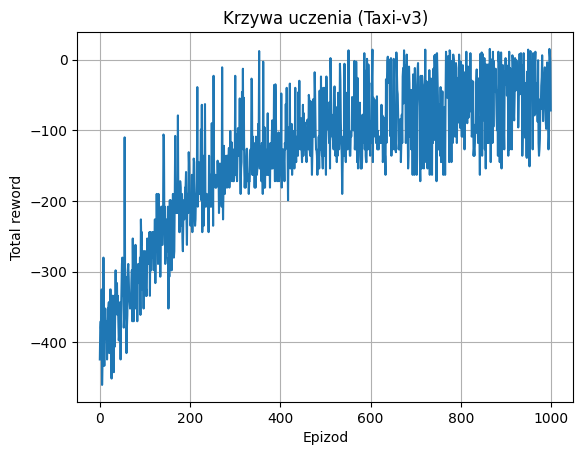

Najlepsza Q-tabela została zapisana do pliku taxi.pkl


In [3]:
env = gym.make("Taxi-v3")

# Parametry Q-learningu
num_states = env.observation_space.n
num_actions = env.action_space.n
q_table = np.zeros((num_states, num_actions))

alpha = 0.1        # Współczynnik uczenia
gamma = 0.9        # Współczynnik dyskontowy
epsilon = 1.0      # Początkowy współczynnik eksploracji
epsilon_min = 0.1
epsilon_decay = 0.995
num_episodes = 1000
max_steps = 100

# Do wykresu
rewards_all_episodes = []

# Dodatkowe zmienne do śledzenia najlepszego wyniku
best_reward = -np.inf

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_rewards = 0

    for _ in range(max_steps):
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state, :])

        new_state, reward, done, truncated, info = env.step(action)

        q_table[state, action] = (1 - alpha) * q_table[state, action] + \
            alpha * (reward + gamma * np.max(q_table[new_state, :]))

        state = new_state
        total_rewards += reward

        if done:
            break

    # Zmniejszanie epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    rewards_all_episodes.append(total_rewards)

    # Sprawdzenie, czy to najlepszy wynik
    if total_rewards > best_reward:
        best_reward = total_rewards
        best_q_table = q_table.copy()  # Zapisanie najlepszej q_table
        print(f"New best reward: {best_reward} in episode {episode}")


env.close()

print("Q-tabela (fragment):")
print(q_table[:5])

# Krzywa uczenia
plt.plot(rewards_all_episodes)
plt.xlabel("Epizod")
plt.ylabel("Total reword")
plt.title("Krzywa uczenia (Taxi-v3)")
plt.grid()
plt.show()

# Zapisanie najlepszej Q-tabeli do pliku
with open("taxi.pkl", "wb") as f:
    pickle.dump(best_q_table, f)
print("Najlepsza Q-tabela została zapisana do pliku taxi.pkl")

# 2. Przestrzeń ciągła


In [4]:
import gymnasium as gym
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array", goal_velocity=0.1)  # default goal_velocity=0
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<Continuous_MountainCarEnv<MountainCarContinuous-v0>>>>>

In [5]:


def run(is_training=True, render=False, discount_factor=0.9, model_name=None):

    env = gym.make('MountainCarContinuous-v0', render_mode='human' if render else None)

    
    learning_rate_a = 0.9999       
    discount_factor_g = discount_factor      # gamma aka discount factor.
    epsilon = 1                  # start episilon at 1 (100% random actions)
    epsilon_decay_rate = 0.001   # epsilon decay rate
    epsilon_min = 0.05           # minimum epsilon
    pos_divisions = 20           # used to convert continuous state space to discrete space
    vel_divisions = 20           # used to convert continuous state space to discrete space
    act_divisions = 10           # used to convert continuous action space to discrete space
    num_episodes = 1200         # number of episodes to run
    max_steps = 5000            # max number of steps per episode
    # Divide position and velocity into segments
    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], pos_divisions)    # Between -1.2 and 0.6
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], vel_divisions)    # Between -0.07 and 0.07

    # Divide action space into discrete segments
    act_space = np.linspace(env.action_space.low[0], env.action_space.high[0], act_divisions, endpoint=False)  # Between -1.0 and 1.0
    act_lookup_space =np.append(act_space, 1)

    if(is_training):
        q = np.zeros((len(pos_space)+1, len(vel_space)+1, len(act_space)+1)) # init a 21x21x11 array
    else:
        # Load q table
        model_name = f'mountain_car_cont_{discount_factor}_g.pkl' if model_name is None else model_name
        f = open(f'{model_name}', 'rb')
        q = pickle.load(f)
        f.close()


    best_reward = -999999        # track best reward
    best_mean_reward = -999999   # track best mean reward
    rewards_per_episode = []     # list to store rewards for each episode
    epsilon_history = []         # List to keep track of epsilon decay
    i = 0                        # episode counter

    while(i<=num_episodes):

        state = env.reset()[0]      # Starting position, starting velocity always 0
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)

        terminated = False          # True when reached goal
        rewards=0
        steps=0

        # Run episode until terminated or number of steps taken > 5000 (5000 is enough for the car to get to the goal randomly)
        while(not terminated and steps<=max_steps):

            if is_training and np.random.rand() < epsilon:
                # Choose random action
                action = env.action_space.sample()

                # Discretize action space
                action_idx = np.digitize(action, act_space)
            else:
                # Choose action with highest Q value
                action_idx = np.argmax(q[state_p, state_v, :])

                # Convert discrete action back to continuous
                action = act_lookup_space[action_idx]

            # Execute action
            new_state,reward,terminated,_,_ = env.step(np.array([action]))

            # Discretize new state space
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)

            if is_training:
                # Update Q table
                q[state_p, state_v, action_idx] = q[state_p, state_v, action_idx] + learning_rate_a * (
                    reward + discount_factor_g*np.max(q[new_state_p, new_state_v,:]) - q[state_p, state_v, action_idx]
                )

            # Update state
            state = new_state
            state_p = new_state_p
            state_v = new_state_v

            # Collect rewards
            rewards+=reward

            steps+=1

        # Track best reward
        if rewards > best_reward:
            best_reward = rewards

        # Store rewards per episode
        rewards_per_episode.append(rewards)

        # Print stats
        if is_training and i!=0 and i%100==0:
            # Calculate mean reward over the last 100 episodes
            mean_reward = np.mean(rewards_per_episode[len(rewards_per_episode)-100:])
            print(f'Episode: {i}, Epsilon: {epsilon:0.2f}, Last Reward: {rewards:0.1f}, Best Reward: {best_reward:0.1f}, Mean Rewards {mean_reward:0.1f}')

            # Graph mean rewards
            mean_rewards = []
            for t in range(i):
                # Calculate mean reward over the t-100 episodes
                mean_rewards.append(np.mean(rewards_per_episode[max(0, t-100):(t+1)]))

            plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
            plt.plot(mean_rewards)
            plt.xlabel('Episode')
            plt.ylabel('Mean Reward')
            plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
            plt.plot(epsilon_history)
            plt.xlabel('Episode')
            plt.ylabel('Epsilon')
            plt.savefig(f'mountain_car_cont_{discount_factor}.png')

            # Save Q table to file on new best reward
            if mean_reward>best_mean_reward:
                best_mean_reward = mean_reward
                print(f'Saving model on new best mean reward: {best_mean_reward:0.1f}')
                f = open(f'mountain_car_cont_{discount_factor}_g.pkl','wb')
                pickle.dump(q, f)
                f.close()

            # Stop, if solved
            # Lower the reward threshold since the mean reward might never get above the threshold
            if mean_reward>env.spec.reward_threshold:
                break

        elif not is_training:
            print(f'Episode: {i} Rewards: {rewards:0.1f}')



        # Decay epsilon
        epsilon = max(epsilon - epsilon_decay_rate, epsilon_min)
        epsilon_history.append(epsilon)

        # Increment episode counter
        i+=1

    env.close()




Training with discount factor: 0.8


C:\Users\serhi\AppData\Roaming\Python\Python312\site-packages\gymnasium\envs\classic_control\continuous_mountain_car.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward -= math.pow(action[0], 2) * 0.1
C:\Users\serhi\AppData\Roaming\Python\Python312\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Episode: 100, Epsilon: 0.90, Last Reward: -164.1, Best Reward: 41.0, Mean Rewards -150.3
Saving model on new best mean reward: -150.3
Episode: 200, Epsilon: 0.80, Last Reward: -162.8, Best Reward: 44.4, Mean Rewards -135.8
Saving model on new best mean reward: -135.8
Episode: 300, Epsilon: 0.70, Last Reward: -156.3, Best Reward: 62.4, Mean Rewards -129.6
Saving model on new best mean reward: -129.6
Episode: 400, Epsilon: 0.60, Last Reward: 28.9, Best Reward: 69.5, Mean Rewards -92.7
Saving model on new best mean reward: -92.7
Episode: 500, Epsilon: 0.50, Last Reward: 26.7, Best Reward: 78.2, Mean Rewards -49.2
Saving model on new best mean reward: -49.2
Episode: 600, Epsilon: 0.40, Last Reward: -9.7, Best Reward: 78.2, Mean Rewards -12.7
Saving model on new best mean reward: -12.7
Episode: 700, Epsilon: 0.30, Last Reward: 19.0, Best Reward: 89.0, Mean Rewards 35.0
Saving model on new best mean reward: 35.0
Episode: 800, Epsilon: 0.20, Last Reward: 33.1, Best Reward: 89.2, Mean Rewards 

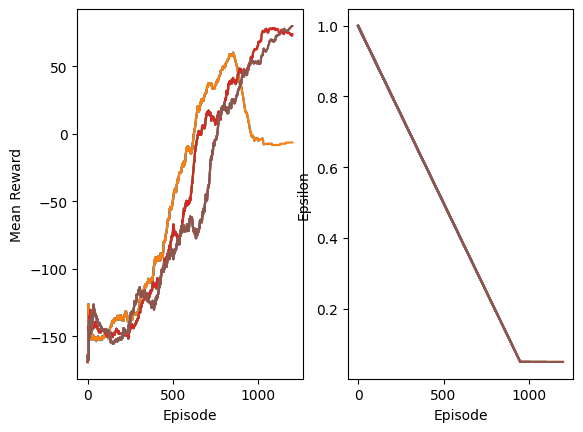

In [6]:
discount_factors = [0.8, 0.9, 0.99]
for d in discount_factors:
    print(f"Training with discount factor: {d}")
    run(is_training=True, render=False, discount_factor=d)

## 2.1 Kod do wizualizacji

In [7]:
# for d in discount_factors:
#     print(f"Testing with discount factor: {d}")
#     run(is_training=False, render=True, discount_factor=d)

In [8]:
# run(is_training=False, render=True, model_name='mountain_car_cont.pkl')

# 3. Własny algorytm

**Zaimplementujemy agenta do gry w grę Blackjack** 

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter

# ---------------------------
# Blackjack Environment
# ---------------------------

class BlackjackDeck:
    def __init__(self):
        self.reset_deck()

    def reset_deck(self):
        self.cards = [v for v in range(1, 14) for _ in range(32)]  # 8 decks = 32 of each card
        self.shuffle()
        self.discarded = []

    def shuffle(self):
        random.shuffle(self.cards)

    def draw_card(self):
        if not self.cards:
            self.cards = self.discarded
            self.discarded = []
            self.shuffle()
        card = self.cards.pop()
        self.discarded.append(card)
        return min(card, 10)  # Face cards become 10

    def get_card_count(self):
        return Counter(min(card, 10) for card in self.cards)


def draw_hand(deck):
    return [deck.draw_card(), deck.draw_card()]

def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21

def sum_hand(hand):
    total = sum(hand)
    return total + 10 if usable_ace(hand) else total

def is_bust(hand):
    return sum_hand(hand) > 21

def score(hand):
    return 0 if is_bust(hand) else sum_hand(hand)

def dealer_play(dealer_hand, deck):
    while sum_hand(dealer_hand) < 16:
        dealer_hand.append(deck.draw_card())
    return dealer_hand

def step(player_hand, dealer_hand, action, deck):
    if action == 1:  # hit
        player_hand.append(deck.draw_card())
        if is_bust(player_hand):
            return player_hand, dealer_hand, -1, True
        return player_hand, dealer_hand, 0, False
    else:  # stick
        dealer_hand = dealer_play(dealer_hand, deck)
        player_score = score(player_hand)
        dealer_score = score(dealer_hand)
        if dealer_score > 21 or player_score > dealer_score:
            return player_hand, dealer_hand, 1, True
        elif player_score < dealer_score:
            return player_hand, dealer_hand, -1, True
        else:
            return player_hand, dealer_hand, 0, True



### 3.1 Monte Carlo

In [ ]:
# ---------------------------
# Monte Carlo Control
# ---------------------------

def mc_control(episodes=100000, epsilon=0.1, gamma=1.0):
    Q = defaultdict(lambda: [0.0, 0.0])
    returns_sum = defaultdict(lambda: [0.0, 0.0])
    returns_count = defaultdict(lambda: [0, 0])
    win_rates = []

    def policy(state):
        return random.choice([0, 1]) if random.random() < epsilon else np.argmax(Q[state])

    wins = 0
    for i in range(1, episodes + 1):
        deck = BlackjackDeck()
        episode = []
        player = draw_hand(deck)
        dealer = draw_hand(deck)
        state = (sum_hand(player), dealer[0], usable_ace(player))
        done = False

        while not done:
            action = policy(state)
            player, dealer, reward, done = step(player, dealer, action, deck)
            episode.append((state, action, reward))
            if not done:
                state = (sum_hand(player), dealer[0], usable_ace(player))

        G = 0
        visited = set()
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            if (state, action) not in visited:
                visited.add((state, action))
                returns_sum[state][action] += G
                returns_count[state][action] += 1
                Q[state][action] = returns_sum[state][action] / returns_count[state][action]

        if episode[-1][2] == 1:
            wins += 1

        if i % 1000 == 0:
            win_rates.append(wins / 1000)
            wins = 0

    return Q, win_rates


### 3.2 Q-Learning

In [ ]:

# ---------------------------
# Q-Learning
# ---------------------------

def q_learning(episodes=100000, alpha=0.1, gamma=1.0, epsilon=0.1):
    Q = defaultdict(lambda: [0.0, 0.0])
    win_rates = []

    def policy(state):
        return random.choice([0, 1]) if random.random() < epsilon else np.argmax(Q[state])

    wins = 0
    for i in range(1, episodes + 1):
        deck = BlackjackDeck()
        player = draw_hand(deck)
        dealer = draw_hand(deck)
        state = (sum_hand(player), dealer[0], usable_ace(player))
        done = False

        while not done:
            action = policy(state)
            next_player, next_dealer, reward, done = step(player[:], dealer[:], action, deck)
            next_state = (sum_hand(next_player), dealer[0], usable_ace(next_player))
            best_next = max(Q[next_state]) if not done else 0
            Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])
            if not done:
                player = next_player
                dealer = next_dealer
                state = next_state

        if reward == 1:
            wins += 1

        if i % 1000 == 0:
            win_rates.append(wins / 1000)
            wins = 0

    return Q, win_rates



    Episode  MonteCarlo Win%  Q-Learning Win%
0      1000            0.359            0.360
1      2000            0.356            0.386
2      3000            0.360            0.400
3      4000            0.371            0.428
4      5000            0.381            0.412
5      6000            0.372            0.380
6      7000            0.374            0.403
7      8000            0.373            0.403
8      9000            0.382            0.394
9     10000            0.395            0.422
10    11000            0.387            0.399
11    12000            0.376            0.413
12    13000            0.455            0.414
13    14000            0.399            0.427
14    15000            0.396            0.386
15    16000            0.398            0.406
16    17000            0.386            0.405
17    18000            0.396            0.407
18    19000            0.398            0.404
19    20000            0.384            0.426
20    21000            0.398      

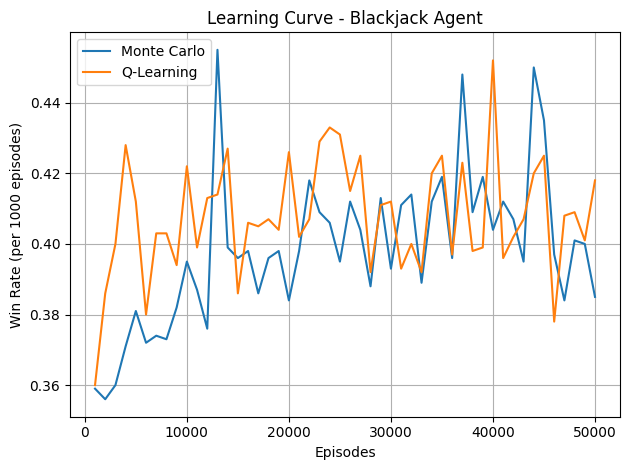

In [25]:
# ---------------------------
# Run + Plot
# ---------------------------


episodes = 50000
_, mc_win_rates = mc_control(episodes)
_, ql_win_rates = q_learning(episodes)

df = pd.DataFrame({
    "Episode": list(range(1000, episodes + 1, 1000)),
    "MonteCarlo Win%": mc_win_rates,
    "Q-Learning Win%": ql_win_rates
})

print(df)

plt.plot(df["Episode"], df["MonteCarlo Win%"], label="Monte Carlo")
plt.plot(df["Episode"], df["Q-Learning Win%"], label="Q-Learning")
plt.xlabel("Episodes")
plt.ylabel("Win Rate (per 1000 episodes)")
plt.title("Learning Curve - Blackjack Agent")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 3.3 Dodajemy opcję zliczania kart

Agent podejmuje decyzję, czy brać kolejną kartę, biorąc pod uwagę karty, które już zostały odrzucone

In [18]:
def estimate_bust_risk(player_hand, deck):
    """
    Estimate the probability of busting if another card is drawn.
    """
    current_sum = sum_hand(player_hand)
    bust_threshold = 22 - current_sum
    if bust_threshold > 10:
        return 0.0  # Cannot bust

    card_counts = deck.get_card_count()
    total_cards = sum(card_counts.values())

    # Count how many cards would cause bust
    bust_cards = sum(qty for val, qty in card_counts.items() if val >= bust_threshold + 1)
    return bust_cards / total_cards if total_cards > 0 else 1.0

def risk_aware_policy(state, player_hand, deck, Q, risk_tolerance=0.3):
    """
    Stick if bust risk is high, hit if risk is low.
    If uncertain, fall back to learned Q-values.
    """
    bust_risk = estimate_bust_risk(player_hand, deck)

    # Conservative: stick if high bust risk
    if bust_risk > 0.5:
        return 0  # stick

    # Aggressive: hit if low bust risk
    if bust_risk < risk_tolerance:
        return 1  # hit

    # Otherwise, use Q-values
    return np.argmax(Q[state])


In [22]:
def q_learning_risk_aware(episodes=10000, alpha=0.1, gamma=0.9):
    Q = defaultdict(lambda: [0.0, 0.0])
    win_rates = []

    wins = 0
    for ep in range(1, episodes + 1):
        deck = BlackjackDeck()
        player = draw_hand(deck)
        dealer = draw_hand(deck)
        state = (sum_hand(player), dealer[0], usable_ace(player))
        done = False

        while not done:
            action = risk_aware_policy(state, player, deck, Q)
            next_player, next_dealer, reward, done = step(player[:], dealer[:], action, deck)
            next_state = (sum_hand(next_player), dealer[0], usable_ace(next_player))
            best_next = max(Q[next_state]) if not done else 0
            Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])

            if not done:
                player = next_player
                dealer = next_dealer
                state = next_state

        if reward == 1:
            wins += 1

        if ep % 1000 == 0:
            win_rates.append(wins / 1000)
            wins = 0

    return Q, win_rates


In [23]:
def mc_control_risk_aware(episodes=10000, gamma=0.9):
    Q = defaultdict(lambda: [0.0, 0.0])
    returns_sum = defaultdict(lambda: [0.0, 0.0])
    returns_count = defaultdict(lambda: [0, 0])
    win_rates = []

    wins = 0
    for ep in range(1, episodes + 1):
        deck = BlackjackDeck()
        episode = []
        player = draw_hand(deck)
        dealer = draw_hand(deck)
        state = (sum_hand(player), dealer[0], usable_ace(player))
        done = False

        while not done:
            action = risk_aware_policy(state, player, deck, Q)
            player, dealer, reward, done = step(player, dealer, action, deck)
            episode.append((state, action, reward))
            if not done:
                state = (sum_hand(player), dealer[0], usable_ace(player))

        G = 0
        visited = set()
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            if (state, action) not in visited:
                visited.add((state, action))
                returns_sum[state][action] += G
                returns_count[state][action] += 1
                Q[state][action] = returns_sum[state][action] / returns_count[state][action]

        if reward == 1:
            wins += 1

        if ep % 1000 == 0:
            win_rates.append(wins / 1000)
            wins = 0

    return Q, win_rates


    Episode  MonteCarlo Win%  Q-Learning Win%
0      1000            0.284            0.415
1      2000            0.259            0.379
2      3000            0.269            0.415
3      4000            0.218            0.398
4      5000            0.237            0.425
5      6000            0.226            0.419
6      7000            0.259            0.429
7      8000            0.251            0.382
8      9000            0.259            0.415
9     10000            0.270            0.415
10    11000            0.263            0.435
11    12000            0.272            0.435
12    13000            0.266            0.422
13    14000            0.252            0.411
14    15000            0.269            0.440
15    16000            0.272            0.425
16    17000            0.261            0.427
17    18000            0.228            0.420
18    19000            0.236            0.423
19    20000            0.266            0.438
20    21000            0.258      

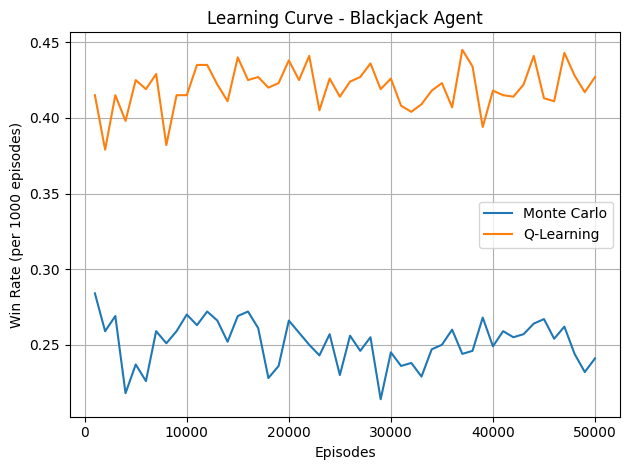

In [24]:
# ---------------------------
# Run + Plot
# ---------------------------


episodes = 50000
_, mc_win_rates = mc_control_risk_aware(episodes)
_, ql_win_rates = q_learning_risk_aware(episodes)

df = pd.DataFrame({
    "Episode": list(range(1000, episodes + 1, 1000)),
    "MonteCarlo Win%": mc_win_rates,
    "Q-Learning Win%": ql_win_rates
})

print(df)

plt.plot(df["Episode"], df["MonteCarlo Win%"], label="Monte Carlo")
plt.plot(df["Episode"], df["Q-Learning Win%"], label="Q-Learning")
plt.xlabel("Episodes")
plt.ylabel("Win Rate (per 1000 episodes)")
plt.title("Learning Curve - Blackjack Agent")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Episode   500 | Win rate: 0.240 | Epsilon: 0.869
Episode  1000 | Win rate: 0.288 | Epsilon: 0.676
Episode  1500 | Win rate: 0.308 | Epsilon: 0.526
Episode  2000 | Win rate: 0.346 | Epsilon: 0.410
Episode  2500 | Win rate: 0.348 | Epsilon: 0.319
Episode  3000 | Win rate: 0.370 | Epsilon: 0.248
Episode  3500 | Win rate: 0.376 | Epsilon: 0.193
Episode  4000 | Win rate: 0.372 | Epsilon: 0.150
Episode  4500 | Win rate: 0.396 | Epsilon: 0.117
Episode  5000 | Win rate: 0.344 | Epsilon: 0.091
   Episodes  DQN Win %
0       500       24.0
1      1000       28.8
2      1500       30.8
3      2000       34.6
4      2500       34.8
5      3000       37.0
6      3500       37.6
7      4000       37.2
8      4500       39.6
9      5000       34.4


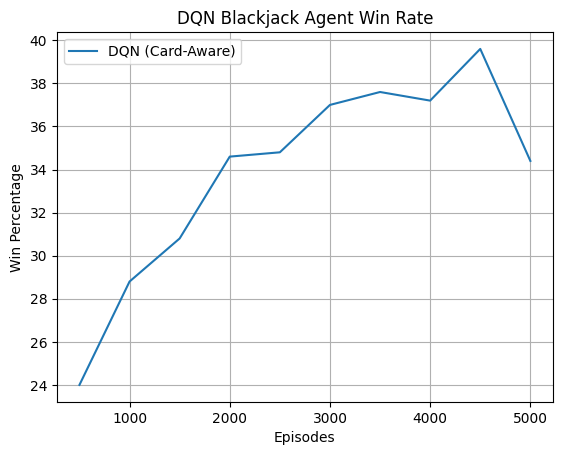

In [28]:
import numpy as np
import tensorflow as tf
from collections import deque, Counter
import random
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------------------------
# HYPERPARAMETERS
# ---------------------------------------------
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.995
BATCH_SIZE = 16
REPLAY_MEMORY_SIZE = 5000
LEARNING_RATE = 0.001
TRAIN_START = 300
MAX_STEPS = 100
EPISODES = 5000
REPLAY_EVERY = 10
UPDATE_TARGET_EVERY = 500

# ---------------------------------------------
# ENVIRONMENT HELPERS (Define if not already)
# ---------------------------------------------
# You must define:
# - BlackjackDeck
# - draw_hand(deck)
# - sum_hand(hand)
# - usable_ace(hand)
# - step(player_hand, dealer_hand, action, deck)

def preprocess_state(player_hand, dealer_card, usable, deck):
    state = [sum_hand(player_hand) / 21, dealer_card / 10, float(usable)]
    card_count = deck.get_card_count()
    total = sum(card_count.values())
    count_vector = [card_count.get(i, 0) / total if total > 0 else 0 for i in range(1, 11)]
    return np.array(state + count_vector, dtype=np.float32)

# ---------------------------------------------
# DQN ARCHITECTURE
# ---------------------------------------------
def build_dqn(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='mse')
    return model

# ---------------------------------------------
# DQN AGENT
# ---------------------------------------------
class DQNAgent:
    def __init__(self):
        self.model = build_dqn(input_dim=13, output_dim=2)  # 13 = [player_sum, dealer_card, usable_ace, card_histogram]
        self.target_model = build_dqn(input_dim=13, output_dim=2)
        self.update_target()
        self.memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.epsilon = EPSILON_START

    def update_target(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice([0, 1])
        q_values = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < TRAIN_START:
            return

        minibatch = random.sample(self.memory, min(len(self.memory), BATCH_SIZE))
        states, targets = [], []

        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(np.array([state]), verbose=0)[0]
            if done:
                target[action] = reward
            else:
                t = self.target_model.predict(np.array([next_state]), verbose=0)[0]
                target[action] = reward + GAMMA * np.amax(t)
            states.append(state)
            targets.append(target)

        self.model.fit(np.array(states), np.array(targets), epochs=1, batch_size=BATCH_SIZE, verbose=0)

        if self.epsilon > EPSILON_MIN:
            self.epsilon *= EPSILON_DECAY

# ---------------------------------------------
# TRAINING LOOP
# ---------------------------------------------
def train_dqn(episodes=EPISODES):
    agent = DQNAgent()
    win_rates = []
    wins = 0

    for ep in range(1, episodes + 1):
        deck = BlackjackDeck()
        player = draw_hand(deck)
        dealer = draw_hand(deck)
        state = preprocess_state(player, dealer[0], usable_ace(player), deck)
        done = False
        steps = 0

        while not done and steps < MAX_STEPS:
            action = agent.act(state)
            next_player, next_dealer, reward, done = step(player[:], dealer[:], action, deck)
            next_state = preprocess_state(next_player, dealer[0], usable_ace(next_player), deck)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            player = next_player
            dealer = next_dealer
            steps += 1

        if reward == 1:
            wins += 1

        if ep % REPLAY_EVERY == 0:
            agent.replay()

        if ep % UPDATE_TARGET_EVERY == 0:
            agent.update_target()

        if ep % 500 == 0:
            win_rate = wins / 500
            win_rates.append(win_rate)
            print(f"Episode {ep:5d} | Win rate: {win_rate:.3f} | Epsilon: {agent.epsilon:.3f}")
            wins = 0

    return agent, win_rates

# ---------------------------------------------
# EXECUTE TRAINING
# ---------------------------------------------
if __name__ == "__main__":
    dqn_agent, win_rates = train_dqn()
    dqn_df = pd.DataFrame({
        'Episodes': np.arange(500, EPISODES + 1, 500),
        'DQN Win %': [round(w * 100, 2) for w in win_rates]
    })

    print(dqn_df)

    plt.plot(dqn_df['Episodes'], dqn_df['DQN Win %'], label='DQN (Card-Aware)')
    plt.xlabel('Episodes')
    plt.ylabel('Win Percentage')
    plt.title('DQN Blackjack Agent Win Rate')
    plt.grid(True)
    plt.legend()
    plt.show()
